<a href="https://colab.research.google.com/github/Krisss993/GAN/blob/main/01_07_GAN_clip_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Install Libraries
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers
!pip install -q opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 MB 5.2 MB/s eta 0:00:00


In [2]:
### Import libraries
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

In [3]:
### Import Clip and ClipSeg repositories

# Install Clip from OpenAI ## MIT Licence
!pip install -q git+https://github.com/openai/CLIP.git

# Install ClipSeg Repo ## MIT Licence
!git clone https://github.com/timojl/clipseg

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
Cloning into 'clipseg'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 232 (delta 72), reused 57 (delta 57), pack-reused 148
Receiving objects: 100% (232/232), 1.40 MiB | 4.93 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [4]:
%cd clipseg

/content/clipseg


In [5]:
### Get the weights for the ClipSeg model should be in the same folder of repository
### These weights don't have MIT licence, they can only be used for research, not for commercial purposes
! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
! unzip -d weights -j weights.zip

--2024-07-01 08:37:25--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [    <=>             ]   9.68M  14.9MB/s    in 0.6s    

2024-07-01 08:37:26 (14.9 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [8]:
# Import Clip and ClipSeg model
import clip
from clipseg.models.clipseg import CLIPDensePredT
# instanciate clipseg model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()

# non-strict mode: decoder weights only (no CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False)

100%|███████████████████████████████████████| 335M/335M [00:10<00:00, 34.0MiB/s]


_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_2.weight',

In [10]:
### Import Stable Diffusion model
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

### The scheduler determine the algorithm used to produce new samples during the denoising process
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

### if you receive a triton error message, that's normal on windows systems


unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Source image size: (1024, 576)


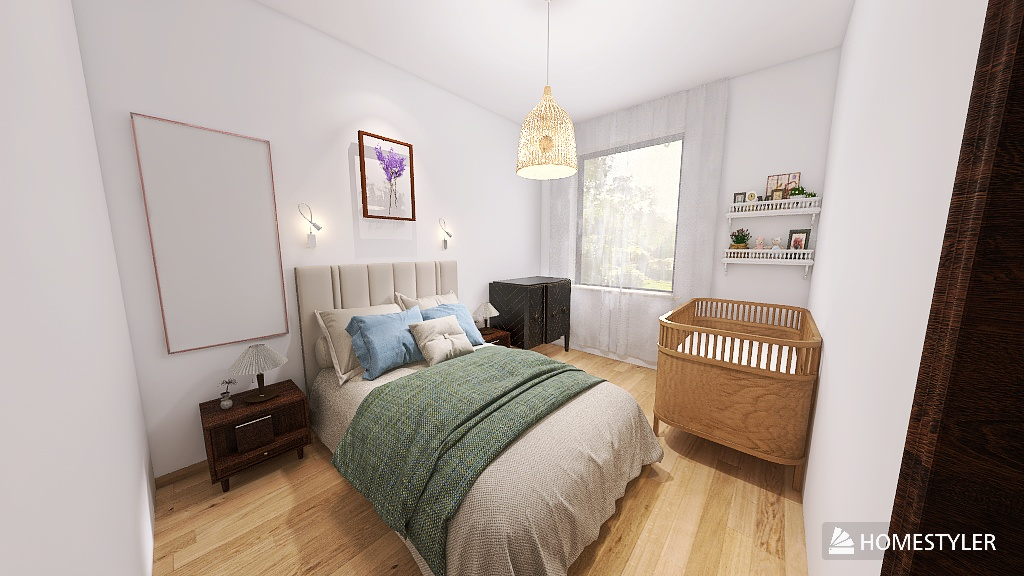

Source image size: (776, 776)


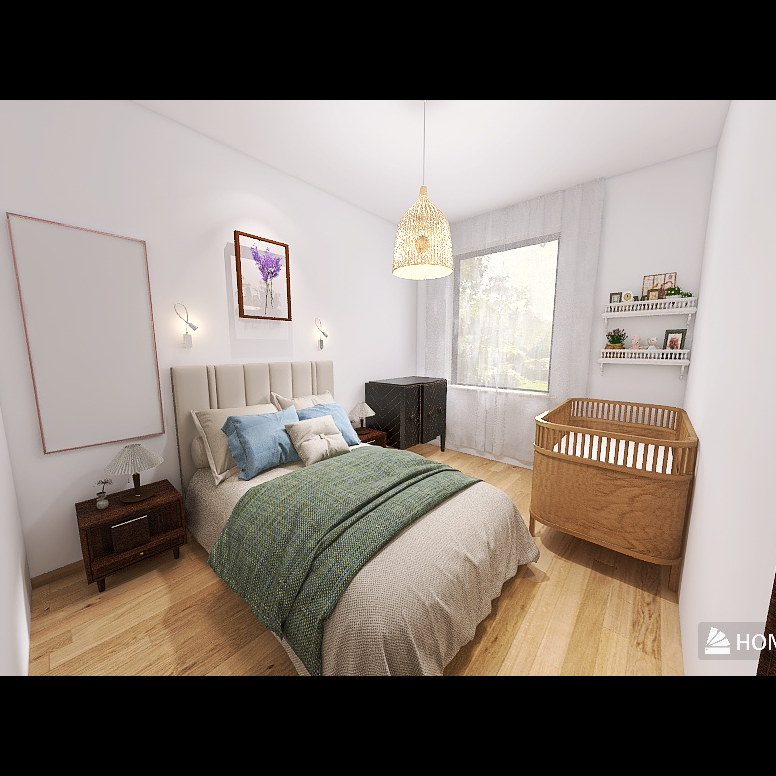

Source image size: (512, 512)


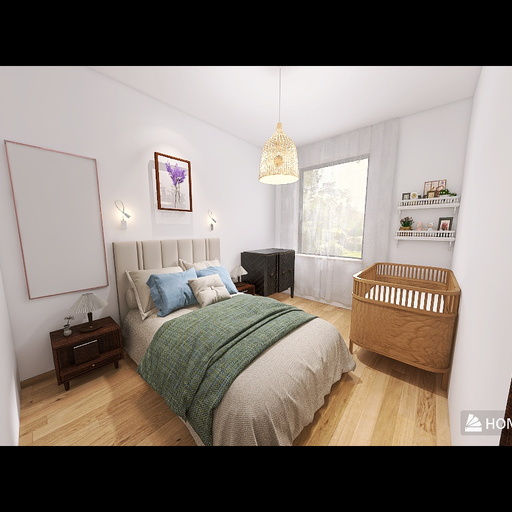

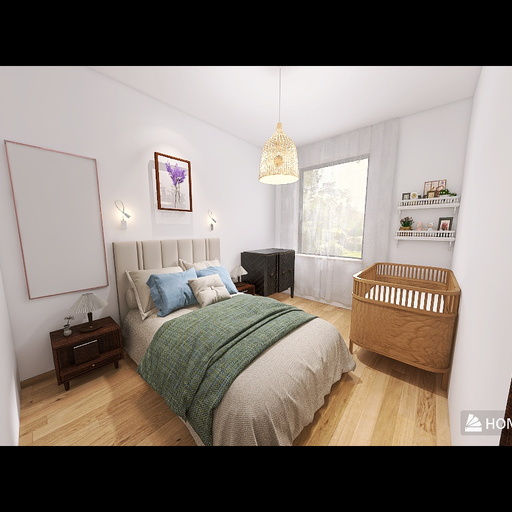

In [24]:
# Upload and unsplash image inside the clipseg folder

target_width, target_height = 512, 512
source_image = Image.open('bedroom2.jpeg')
print(f'Source image size: {source_image.size}')
display(source_image)
source_image = source_image.crop(box=(124, -100, source_image.size[0]-124, source_image.size[1]+100))
print(f'Source image size: {source_image.size}')
display(source_image)
source_image = source_image.resize((target_width, target_height), Image.LANCZOS)
print(f'Source image size: {source_image.size}')

# Setup transformations to ba applied to the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor_image = transform(source_image).unsqueeze(0)
display(source_image)

In [30]:
# Creating masks for the parts of the clothes to be indentified

prompts = ['a bed', 'a mirror', 'a window', 'lamp']

# using clipseg to identify elements in the picture
with torch.no_grad():
  preds = model(tensor_image.repeat(len(prompts), 1, 1, 1), prompts)[0]

In [28]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


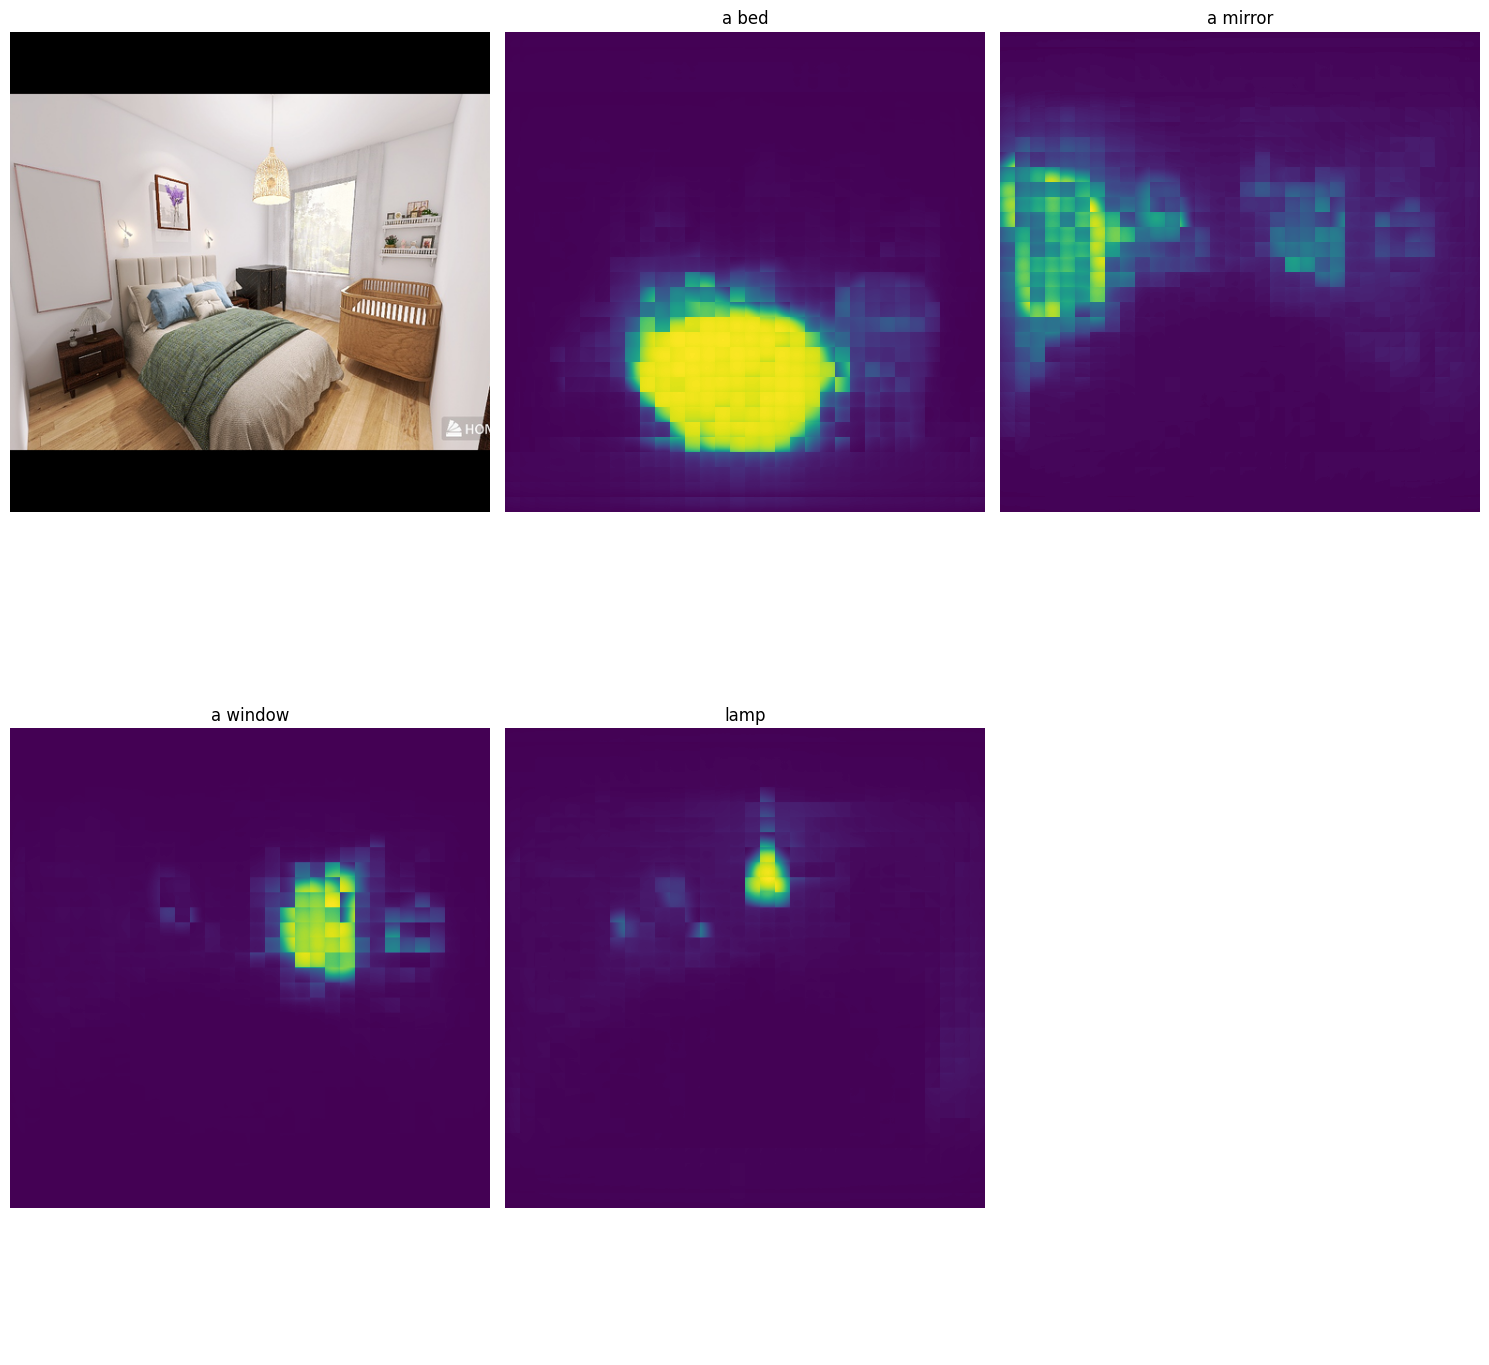

In [31]:
create_image_grid(source_image, preds, prompts, 2, 3)

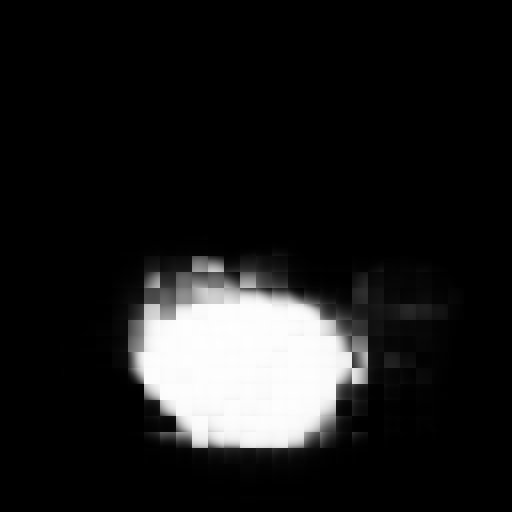

In [39]:
# Decide which mask you want to do inpainting with. In this case we pick the skirt which is mask number 1
mask_number = 0

# Normalize mask values by computing the area under Gaussan probability density function, calculating the cumulative distribution with ndtr
processed_mask = torch.special.ndtr(preds[mask_number][0])

stable_diffusion_mask = transforms.ToPILImage()(processed_mask)
display(stable_diffusion_mask)

In [44]:
### Setup transformation prompts
num_images_per_prompt = 4
inpainting_prompts = ["water bed",  "blue flowers", "a dragon", "a tent"]

generator = torch.Generator(device="cuda").manual_seed(77) # 155, 77,

### Run Stable Difussion pipeline in inpainting mode
encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

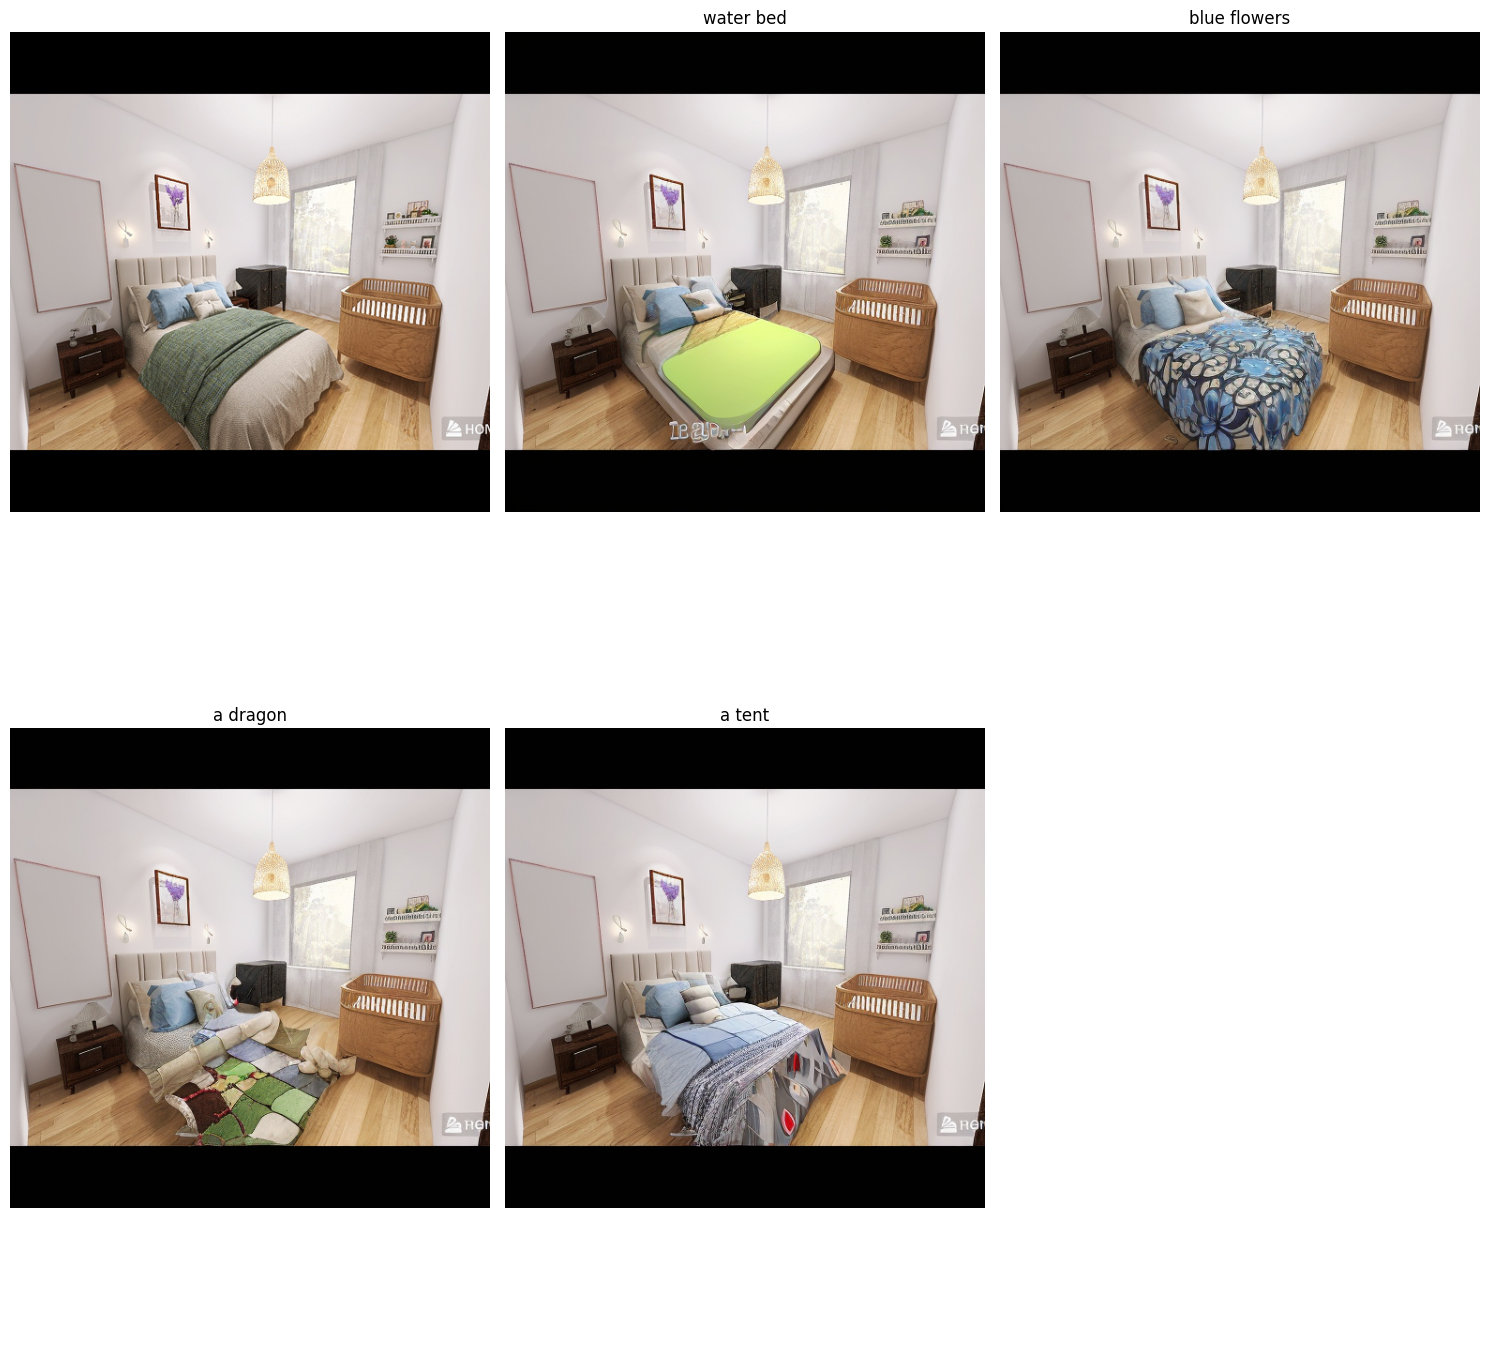

In [45]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)

In [46]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Normalize tensor images, convert them to 3-channel format, and blend them with the original image
        images = [
            cv2.add(
                original_image_np,
                cv2.applyColorMap((torch.sigmoid(img).squeeze(0).numpy() * 255).astype(np.uint8), cv2.COLORMAP_HOT)[:,:,[2,1,0]] * (torch.sigmoid(img).squeeze(0).numpy() > 0.5).astype(np.uint8)[:, :, np.newaxis]
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

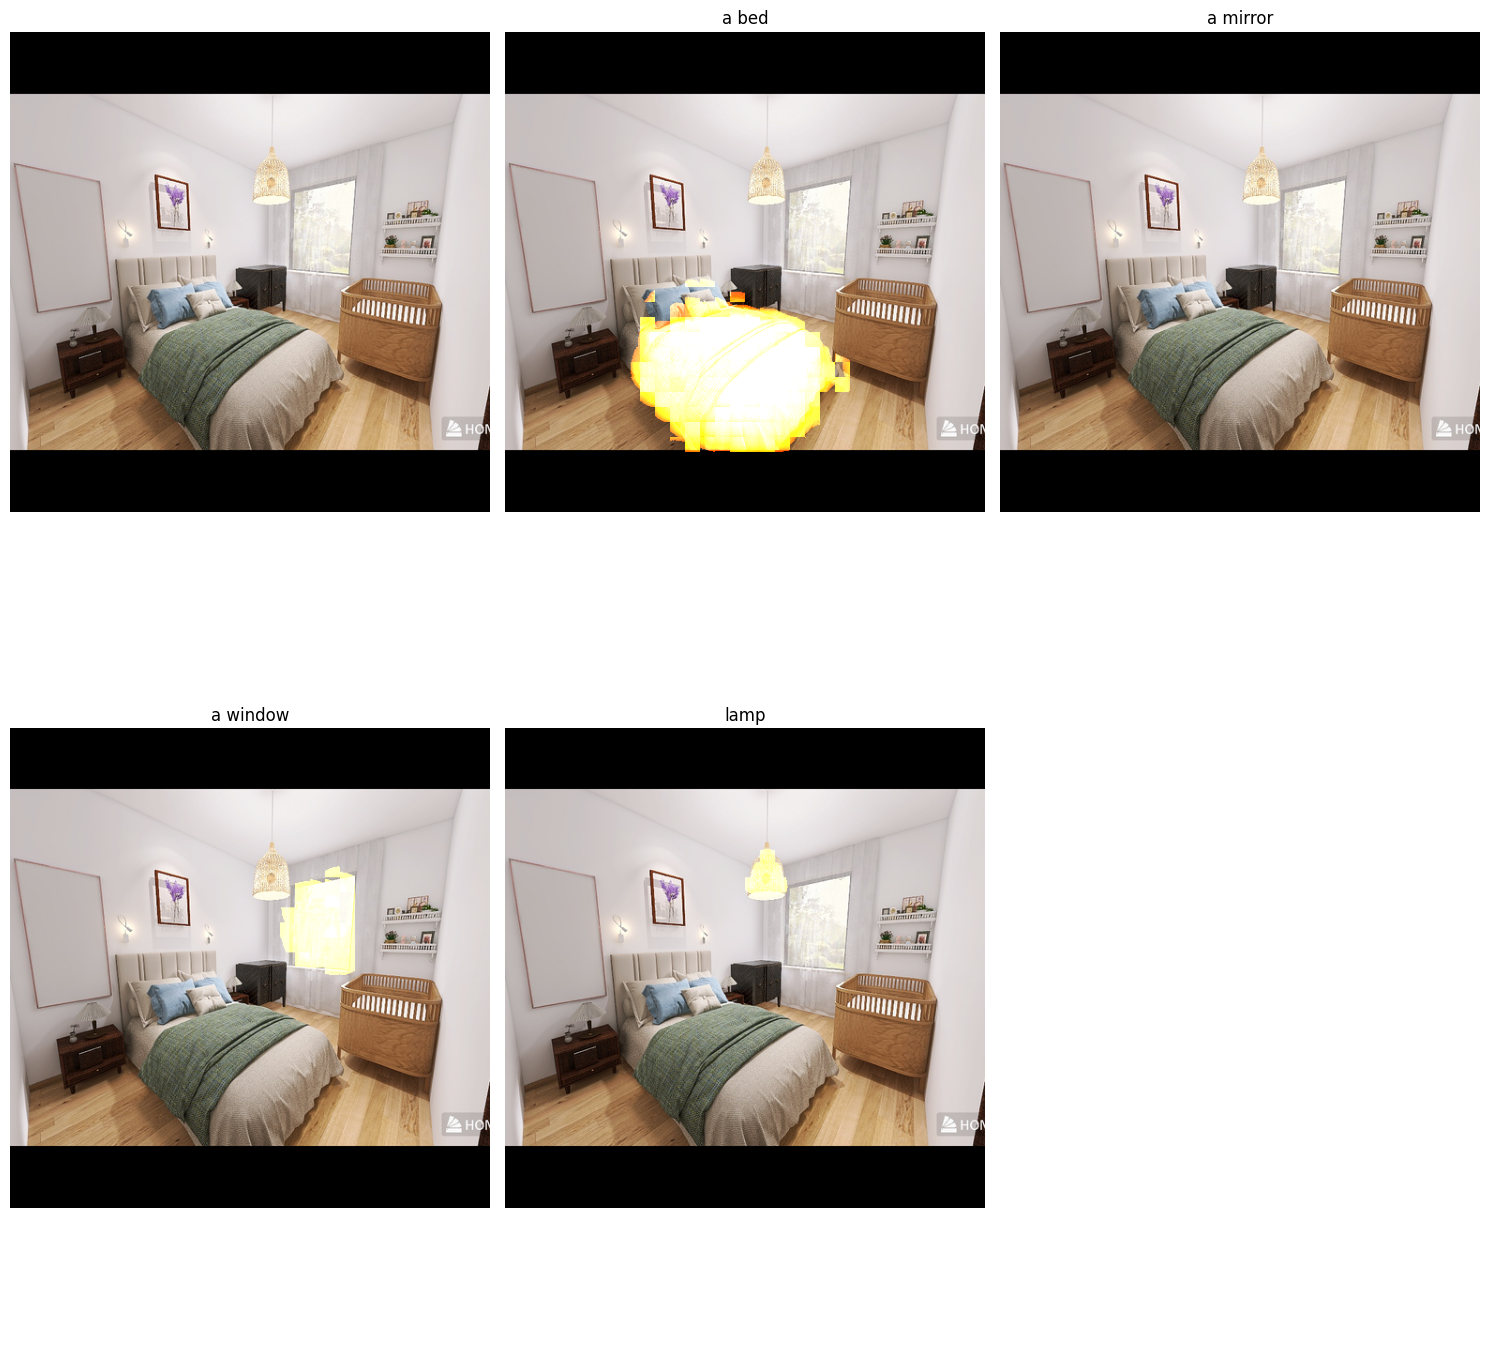

In [47]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

In [48]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Normalize tensor images, convert them to 3-channel format, and blend them with the original image
        images = [
            np.where(
                (torch.sigmoid(img).squeeze(0).numpy() > 0.5)[:, :, np.newaxis],
                cv2.applyColorMap((torch.sigmoid(img).squeeze(0).numpy() * 255).astype(np.uint8), cv2.COLORMAP_HOT)[:,:,[2,1,0]],
                original_image_np
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


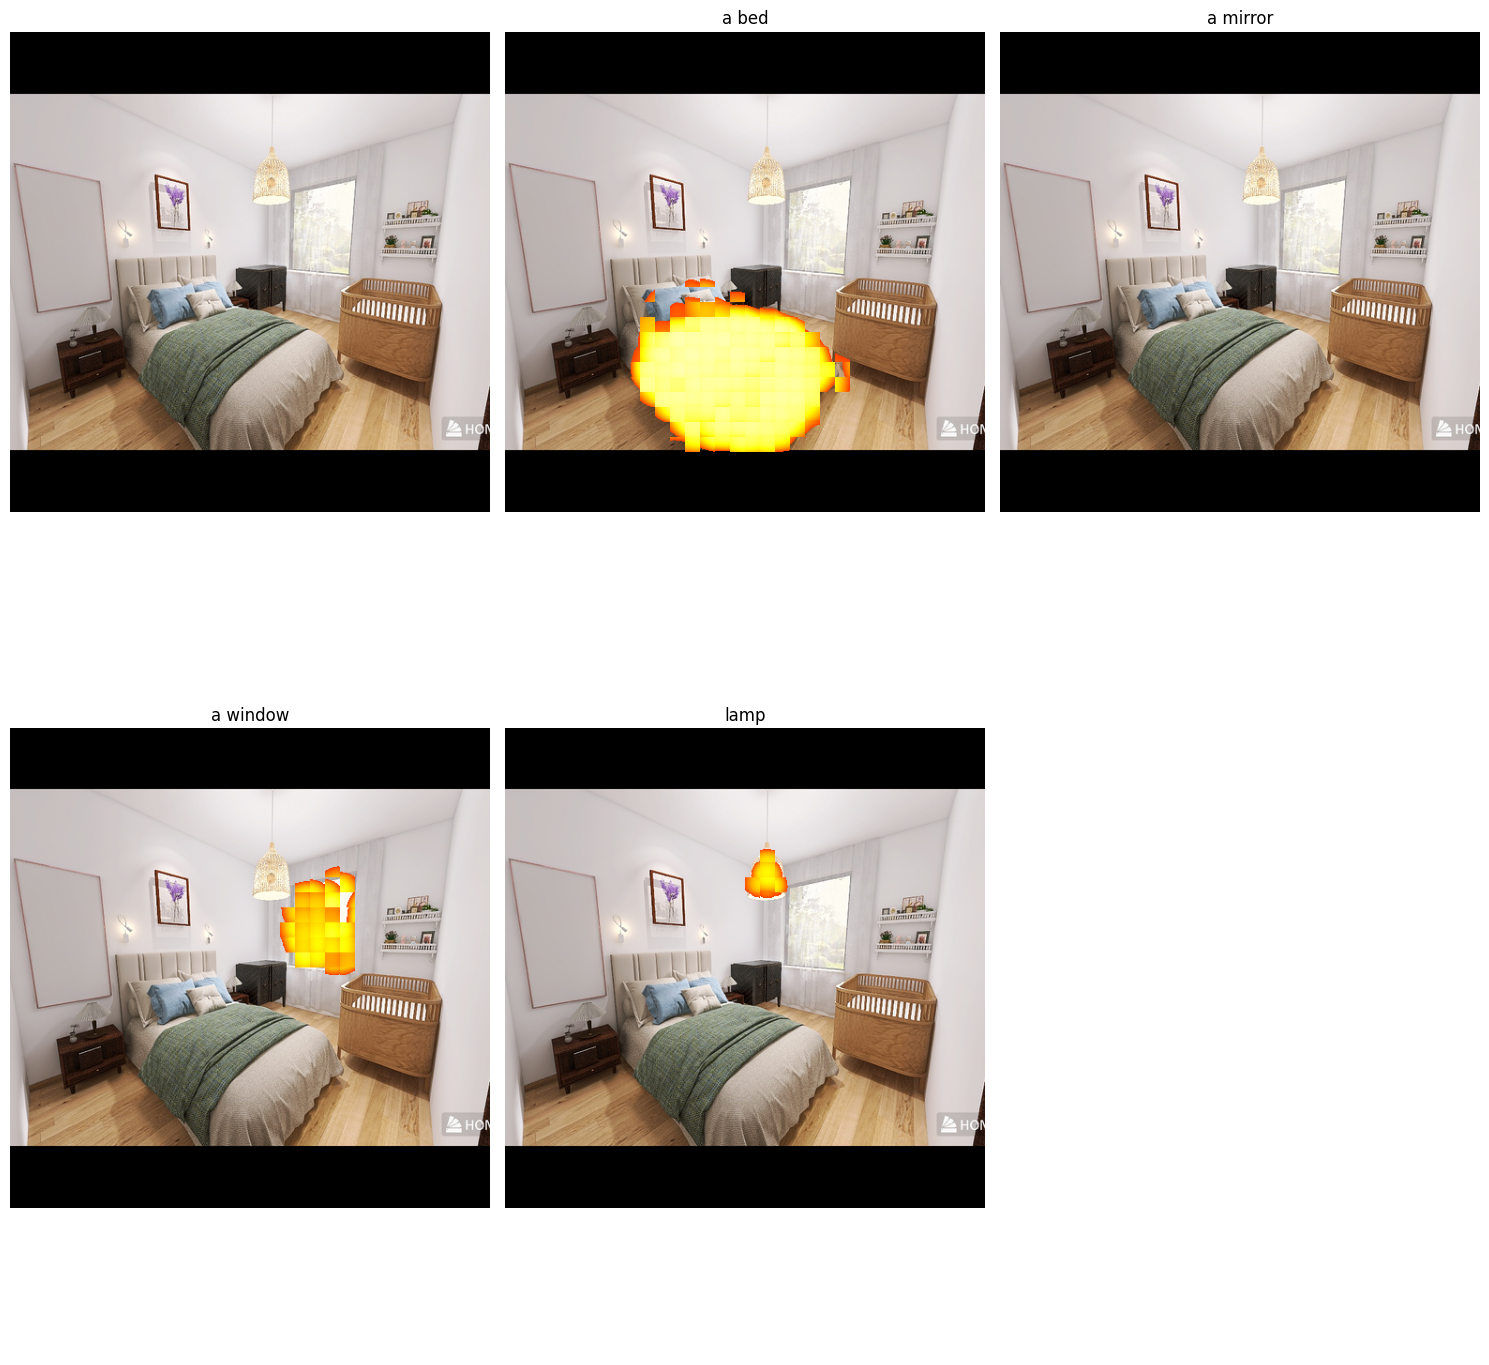

In [49]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)

In [50]:
def create_image_plus_masks_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert the original image to a NumPy array
        original_image_np = np.array(original_image)

        # Create a solid yellow color mask with the same size as the original image
        yellow_mask = np.zeros_like(original_image_np)
        yellow_mask[..., 0] = 255  # Red channel
        yellow_mask[..., 1] = 255  # Green channel

        # Normalize tensor images, create a binary mask, and blend them with the original image
        images = [
            np.where(
                (torch.sigmoid(img).squeeze(0).numpy() > 0.5)[:, :, np.newaxis],
                yellow_mask,
                original_image_np
            )
            for img in images
        ]

        # Convert the blended images back to PIL format
        images = [to_pil_image(img) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

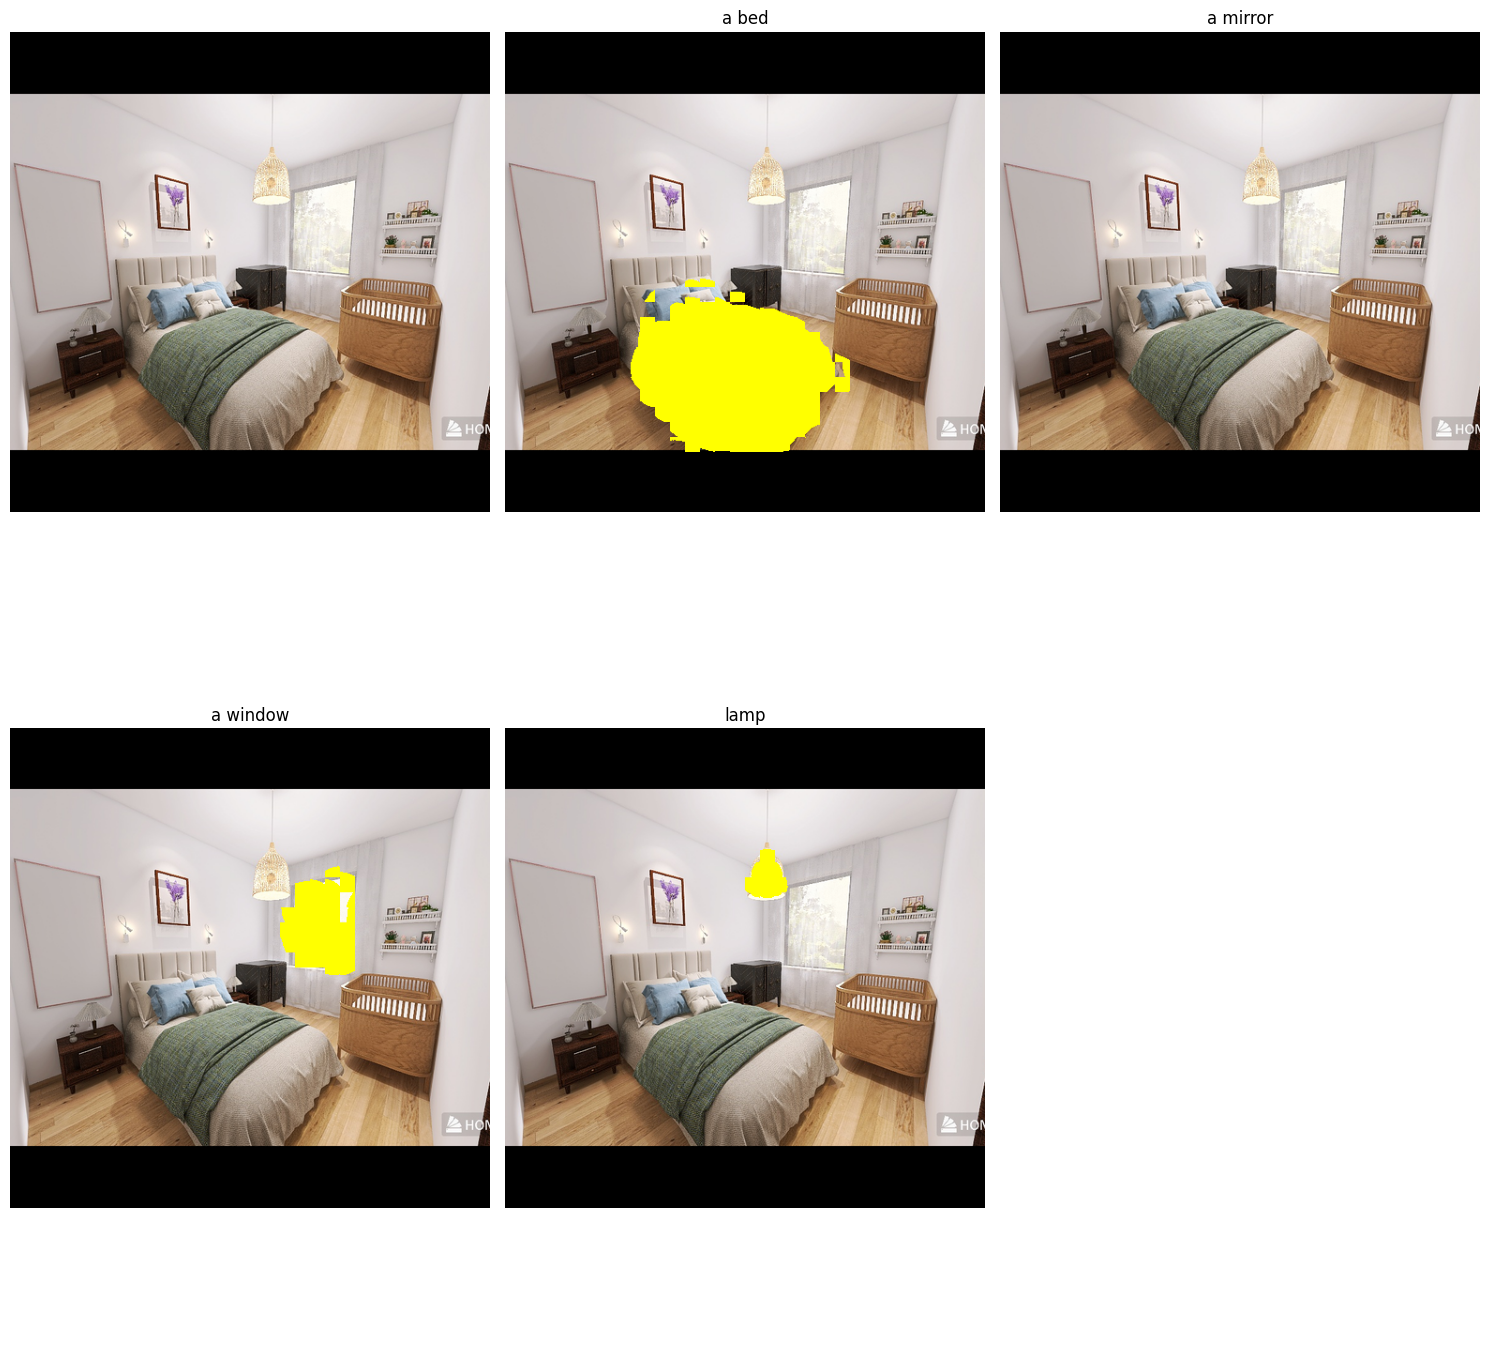

In [51]:
create_image_plus_masks_grid(source_image, preds, prompts, 2, 3)